In [359]:
import cairo
import numpy as np
from noise import snoise2, snoise4
from matplotlib import pyplot as plt
from PIL import Image
from enum import Enum
from scipy import ndimage
import math
import time
import copy
import random

In [360]:
_MAXX_ = 500
_MAXY_ = 500
_GRAV_ = 9.8

In [361]:
Wentworth = Enum('Wentworth', [
    'Clay', 
    'Silt_vf', 'Silt_f', 'Silt_m', 'Silt_c', 
    'Sand_vf','Sand_f','Sand_m','Sand_c','Sand_vc',
    'Granules', 'Pebbles_f', 'Pebbles_m', 'Pebbles_c', 'Pebbles_vc', 
    'Cobbles'])

In [362]:
'''Everything is hand entered and tuned, please go ahead and tune to your liking
size => particle size
edCurve => list index is low -> high stream velocity, list values is the resistance to moving vs stream velocity
'''
Hjulstrom = {
    Wentworth.Clay.name:
    {
        "size":0.001,
        "edCurve":[1.0, 1.0, 0.9999, 0.9999, 0.999, 0.999, 0.999, 0.99, 0.99, 0.9],
    },
        Wentworth.Silt_vf.name:
    {
        "size":0.004,
        "edCurve":[1.01, 1.0001, 0.9999, 0.9999, 0.99, 0.99, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Silt_f.name:
    {
        "size":0.008,
        "edCurve":[1.1, 1.01, 1.0, 0.9999, 0.99, 0.99, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Silt_m.name:
    {
        "size":0.016,
        "edCurve":[1.2, 1.02, 1.0, 1.0, 0.9999, 0.999, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Silt_c.name:
    {
        "size":0.031,
        "edCurve":[1.3, 1.04, 0.99999, 0.99999, 0.999, 0.999, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Sand_vf.name:
    {
        "size":0.062,
        "edCurve":[1.4, 1.08, 0.999999, 0.999999, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_f.name:
    {
        "size":0.125,
        "edCurve":[1.5, 1.09, 1.01, 1.0, 0.9999, 0.99, 0.99, 0.9, 0.8, 0.7],
    },
        Wentworth.Sand_m.name:
    {
        "size":0.250,
        "edCurve":[1.6, 1.1, 1.1, 0.999999, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_c.name:
    {
        "size":0.5,
        "edCurve":[1.7, 1.2, 1.2, 1.0, 1.0, 1.0, 1.0, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_vc.name:
    {
        "size":1.0,
        "edCurve":[1.8, 1.3, 1.0, 1.0, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_vc.name:
    {
        "size":1.0,
        "edCurve":[1.8, 1.3, 1.0, 1.0, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Granules.name:
    {
        "size":2.0,
        "edCurve":[1.9, 1.4, 1.1, 1.0, 0.999, 0.999, 0.999, 0.999, 0.99, 0.8],
    },
        Wentworth.Pebbles_f.name:
    {
        "size":4.0,
        "edCurve":[2.1, 1.5, 1.2, 1.1, 1.0, 1.0, 0.999, 0.99, 0.99, 0.8],
    },
        Wentworth.Pebbles_m.name:
    {
        "size":8.0,
        "edCurve":[2.2, 1.6, 1.3, 1.2, 1.0, 1.0, 1.0, 0.999, 0.99, 0.9],
    },
        Wentworth.Pebbles_c.name:
    {
        "size":16.0,
        "edCurve":[2.3, 1.7, 1.4, 1.3, 1.0, 1.0, 1.0, 0.999, 0.999, 0.99],
    },
        Wentworth.Pebbles_vc.name:
    {
        "size":32.0,
        "edCurve":[2.4, 1.8, 1.5, 1.4, 1.0, 1.0, 1.0, 0.999, 0.999, 0.99],
    },
        Wentworth.Cobbles.name:
    {
        "size":64.0,
        "edCurve":[2.5, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.999],
    },
}

In [363]:
class Sediment():    

    grainType = None
    activeLayer = None
    
    def __init__(self, grain = None):
        if grain != None:
            if type(grain) != Wentworth:
                #invalid instatiation
                print("Grain must be an Enum of type Wentworth, Nothing Created")
                del(self)            
                return None
        else:            
            #invalid instatiation
            print("Nothing Created")
            del(self)
            return None
        
        #valid instatiation
        self.grainType = grain
        
        self.initActiveLayer()
        
    def initActiveLayer(self):
        self.activeLayer = np.zeros((_MAXX_, _MAXY_))
        
        for y in range(_MAXY_):
            for x in range(_MAXY_):
                self.activeLayer[x, y] = self.getSediment(x, y)
    
    def displayDistribution(self):
        plt.subplot()
        plt.axis('off')
        plt.title("Distribution of " + self.grainType.name)
        plt.pcolormesh(self.activeLayer, cmap='summer')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
        
    def getSediment(self, x, y, z = 0):
        ##sediment placement is a smooth noise function
        no = snoise4(x / 100.0, y / 100.0, 100.0 * self.grainType.value, z / 100.0, 4)

        ## add some stepping
        amountOfStepping = 10.0
        no = np.floor(no * amountOfStepping) / amountOfStepping 
        
        #scramble densities
        no = (snoise2(no * 123.0, 456.0 * self.grainType.value) + 1.0) / 2.0
        
        return no

    def getActiveLayer(self, x, y):
        return self.activeLayer[x, y]
    
    def setActiveLayer(self, x, y, value):
        self.activeLayer[x, y] = value
 
'''
### TESTING
sediment_a = Sediment()
##Nothing Created

sediment_b = Sediment('Clay')
##Grain must be an Enum of type Wentworth, Nothing Created

clay = Wentworth.Clay

sediment_c = Sediment(clay)
print("Sediment value gotten: ", sediment_c.getSediment(1, 2, 3))
##Sediment value gotten: |Some Value|
sediment_c.displayDistribution()
'''

'\n### TESTING\nsediment_a = Sediment()\n##Nothing Created\n\nsediment_b = Sediment(\'Clay\')\n##Grain must be an Enum of type Wentworth, Nothing Created\n\nclay = Wentworth.Clay\n\nsediment_c = Sediment(clay)\nprint("Sediment value gotten: ", sediment_c.getSediment(1, 2, 3))\n##Sediment value gotten: |Some Value|\nsediment_c.displayDistribution()\n'

In [460]:
class Water():
    waterLayer = np.random.rand(_MAXX_, _MAXY_)
    velocity = np.zeros((_MAXX_, _MAXY_))
    
    def readWater(self, x, y):
        return self.activeSedimentLayer[x, y]
    
    def addWater(self, x, y, value):
        self.activeSedimentLayer[x, y] += value
        
    def displayVelocity(self):
        mn = np.amin(self.velocity)
        mx = np.amax(self.velocity)
        
        plt.subplot()
        plt.axis('off')
        plt.title("Water velocity min:" + str(mn) + " max:" + str(mx) )
        plt.pcolormesh(self.velocity, cmap='turbo')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
    
    def displayDistribution(self):
        mn = np.amin(self.waterLayer)
        mx = np.amax(self.waterLayer)
        
        plt.subplot()
        plt.axis('off')
        plt.title("Water distribution min:" + str(mn) + " max:" + str(mx) )
        plt.pcolormesh(self.waterLayer, cmap='winter')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
    
    def calcVelocityMap(self, dx, dy):
        '''
        dx = np.expand_dims(dx, 1)
        dy = np.expand_dims(dy, -1)
        
        norm = copy.copy(np.expand_dims(dx + dy, -1))
        norm.resize((_MAXX_, _MAXY_, 3))
        
        up = np.array([0.0, 0.0, 1.0])
        
        a = np.sin(np.arccos(np.dot(norm, up))) * self.waterLayer * _GRAV_
        a = np.where(np.isnan(a), 0, a)
        self.velocity = self.velocity + a
        return self.velocity
        
        '''
        up = np.array([0.0, 0.0, 1.0])
        
        norm = np.zeros((3))
        
        vel = np.zeros((_MAXX_, _MAXY_))
        
        for y in range(_MAXY_):
            for x in range(_MAXX_):
                norm[0] = dx[x, y] 
                norm[1] = dy[x, y]
                norm[2] = 0.0

                vel[x, y] = np.sin(np.arccos((norm @ up))) * self.waterLayer[x, y] * _GRAV_
        
        self.velocity =  self.velocity + vel
        
        return self.velocity
        
        
    def moveWater(self, angleOfSlopeMap, 
                  deltaTime = 1.0, 
                  flow = 0.2, 
                  drag = 0.99, 
                  evap = 0.99999,
                  rainProb = 0.1,
                  rainIntensity = 0.2,
                 ):
        nextWater = copy.copy(self.waterLayer) * evap
        
        for y in range(_MAXY_):
            for x in range(_MAXX_):
                dx = (np.cos(angleOfSlopeMap[x,y]) * self.velocity[x, y] * deltaTime)
                dy = (np.sin(angleOfSlopeMap[x,y]) * self.velocity[x, y] * deltaTime)
                tx = int(x + dx) % _MAXX_
                ty = int(y + dy) % _MAXY_
                nextWater[tx, ty] = ((1 - flow) * self.waterLayer[tx, ty]) + (flow * self.waterLayer[x, y])
        
        self.velocity = self.velocity * drag
        
        self.waterLayer = copy.copy(nextWater) 

In [485]:
class Terrain():
    _OFFSET_ = [4562, -9999] ##SEED for random noise
    
    heightMap = None
    sedimentData = None
    
    def __init__(self, sedimentData):
        self.heightMap = np.zeros((_MAXX_, _MAXY_))
        self.sedimentData = sedimentData
        self.generateLand()
            
    
    def generateTestLand(self):
        for y in range(_MAXY_):
            for x in range(_MAXX_):
                self.heightMap[x, y] = math.dist([_MAXX_/2.0, _MAXY_/2.0], [x, y])
                
    def generateLand(self):
         for y in range(_MAXY_):
            for x in range(_MAXX_):
                
                offsetx = snoise2(x / 50.0, y / 50.0 + self._OFFSET_[0]) * 1.0
                offsety = snoise2(x / 500.0, y / 500.0 + self._OFFSET_[1]) * 100.0
                self.heightMap[x, y] = ((snoise2(x / (800.0 + offsetx) + self._OFFSET_[0], y / (800.0 + offsety) + self._OFFSET_[1], 4) + 1.0) / 2.0) ** 0.5
    
    def displayContour(self, contourFreq, threshold = 0.99):
        
        contourMap = copy.copy(self.heightMap)
        
        contourMap = np.where(np.sin(contourMap * contourFreq) > threshold, 1, 0)
                
        plt.subplot()
        plt.axis('off')
        plt.title("Contour freq:"+ str(contourFreq) + " Threshold:"+ str(threshold) + "")
        plt.pcolormesh(contourMap, cmap='binary')

        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
                
    def displayHeight(self): 
        mn = np.amin(self.heightMap)
        mx = np.amax(self.heightMap)
        plt.subplot()
        plt.axis('off')
        plt.title("height min:" + str(mn) + " max:" + str(mx))
        plt.pcolormesh(self.heightMap, cmap='viridis')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
    
    def calcAngleOfSlope(self):
        '''angle of slope map
        '''
        a, b = self.calcSlopeNormal()
        
        c = np.zeros((_MAXX_, _MAXY_))
        
        c = np.arctan2(a, b) 

        return c
    
    def displayAngleOfSlope(self):
        angleOfSlopeMap = self.calcAngleOfSlope()
        
        mn = np.amin(angleOfSlopeMap)
        mx = np.amax(angleOfSlopeMap)

        plt.subplot()
        plt.axis('off')
        plt.title("Slope facing angle min:" + str(math.degrees(mn)) + " -> " + str(math.degrees(mx)) + " degrees")        
        plt.pcolormesh(angleOfSlopeMap, cmap='tab20b')

        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
        
    def calcSlopeNormal(self):
        x = np.roll(self.heightMap, -1, 0) - np.roll(self.heightMap, 1, 0)
        y = np.roll(self.heightMap, -1, 1) - np.roll(self.heightMap, 1, 1)

        return (x,y)

    def displayNormalMap(self):
        dx, dy = self.calcSlopeNormal()
        
        norm = np.zeros((_MAXX_, _MAXY_, 3))
        for y in range(_MAXY_):
            for x in range(_MAXX_):
                norm[x, y, 0] = dx[x, y] 
                norm[x, y, 1] = dy[x, y]
                norm[x, y, 2] = 0.5
        
        norm = norm - np.amin(norm)
        norm = norm / np.amax(norm)
        plt.imshow(norm)
        

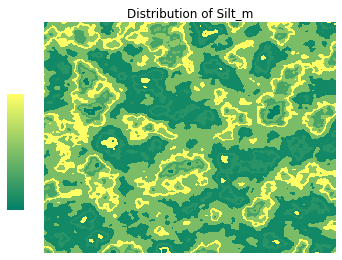

In [486]:
#initialize sediment layers
sedimentData = {}

for s in Wentworth:
    newSediment = Sediment(s)
    sedimentData[s.name] = newSediment


terrain = Terrain(sedimentData) #create new terrain object

terrain.generateTestLand() #test terrain with height map as a cone

terrain.sedimentData[Wentworth.Silt_m.name].displayDistribution() #distribution of sediments display demo

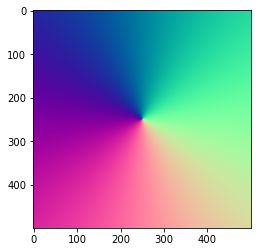

In [487]:
'''
Normal Map  - with cone test data
'''
terrain.displayNormalMap()

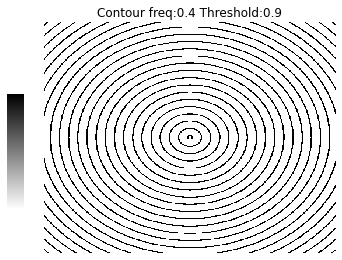

In [488]:
'''
Contour map  - with cone test data
'''
terrain.displayContour(0.4, 0.9)

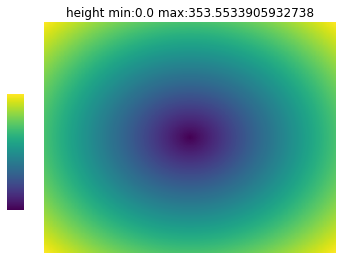

In [489]:
'''
Height map  - with cone test data
'''
terrain.displayHeight()

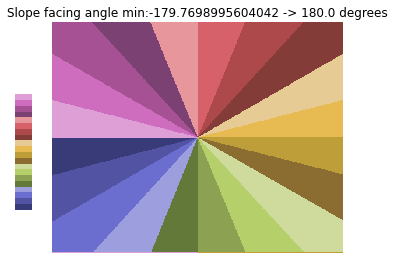

In [493]:
'''
Angle of Slope map - with cone test data
'''
terrain.displayAngleOfSlope()

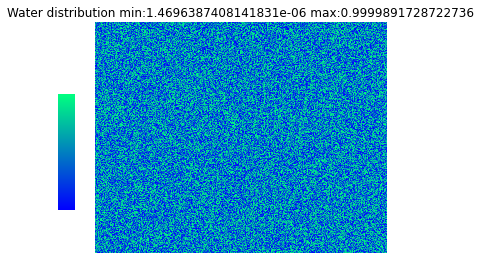

In [494]:
'Create a new water object'
water = Water()
water.displayDistribution() #distribution should be uniform high frequency noise

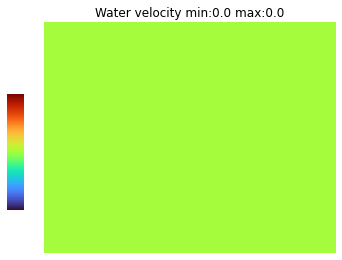

In [495]:
water.displayVelocity() #the starting velocity is zero

1.172157874 s each loop


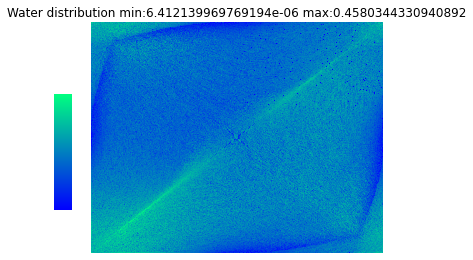

In [496]:
'Water distribution after moving water a number of iterations  - with cone test data'

dx, dy = terrain.calcSlopeNormal()

n = 20

t1 = time.clock_gettime_ns(time.CLOCK_REALTIME)
for i in range(n):
    water.calcVelocityMap(dx, dy)
    water.moveWater(
        angleOfSlopeMap, 
        deltaTime = 1.0, 
        flow = 0.2, 
        drag = 0.99, 
        evap = 0.9,
        rainProb = 0.2,
        rainIntensity = 0.9,
)
t2 = time.clock_gettime_ns(time.CLOCK_REALTIME)

print(str( ((t2 - t1) / 1000000000.0) / n) + " s each loop")

water.displayDistribution()


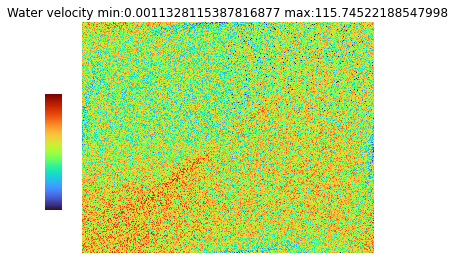

In [497]:
'''
Water velocity after moving water a number of iterations.
'''
water.displayVelocity()

In [498]:
'''
Terrain tested with cone shows some artifacts, this is probably due to corner to corner, cells are further 
apart than cells edge to edge. This may be mitigated with noise and letting values average into their neighbors.
'''

'\nTerrain tested with cone shows some artifacts, this is probably due to corner to corner, cells are further \napart than cells edge to edge. This may be mitigated with noise and letting values average into their neighbors.\n'